### makemore: lect03


### day14

- 202403120630--202403120800

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Any

### Constants

In [52]:
RANDOM_SEED = 10
NUM_BLOCKS = 3
NUM_DIM_CHARS = 2
NUM_HIDDEN = 20

### Random Generator

In [65]:
import random
import numpy as np

rand_gen = torch.Generator().manual_seed(RANDOM_SEED)
RAND_GEN = rand_gen

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Read File

In [53]:
words = open("names.txt").read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

### Make Mappings: `chr -> int` and `int -> chr`

In [54]:
ord("a"), ord("z"), ord("z") - ord("a") + 1, chr(ord("a")), chr(ord("z"))

(97, 122, 26, 'a', 'z')

In [55]:
itos = {i - ord("a") + 1: chr(i) for i in range(ord("a"), ord("z") + 1)}
itos[0] = "."

stoi = {s: i for i, s in itos.items()}

# stoi
# itos

In [17]:
chars = sorted(list(set("".join(words))))
chars[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [18]:
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

### Get Data

In [49]:
def get_data(words: List[str], num_blocks: int = 3, stoi=stoi) -> (List[torch.tensor], List[torch.tensor]):
    """get data"""

    X, Y = [], []


    ### tese lines are for testing:
    # for word in words[:5]:
        # print("-" * 80)

    for word in words:
        context = [0] * num_blocks
        for ch in word + ".":
            i = stoi[ch]
            # append the current char ch, i.e. the index i into Y;
            # at the same time append the current context into X;
            # (the context up to now) contains letters that preeced the char ch
            # print(" ".join((itos[ix] for ix in context)), "--->", ch)
            X.append(context)
            Y.append(i)
            context = context[1: ] + [i]
           

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [50]:
get_data(words)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [59]:
num_blocks = NUM_BLOCKS
X, Y = get_data(words, num_blocks=num_blocks)

In [60]:
X[:10]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]])

In [61]:
Y[:10]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])

### Split Data: `train`, `val/dev`, and `test`

In [76]:
X.shape, X.shape[0]

(torch.Size([228146, 3]), 228146)

In [77]:
Y.shape, Y.shape[0]

(torch.Size([228146]), 228146)

In [78]:
indexes = torch.randperm(X.shape[0], generator=rand_gen)
indexes[:10]

tensor([ 62102,   4877, 179290, 160688, 210586, 157978,   8491, 107774,  53805,
         35852])

In [79]:
# this list changes over time?!
torch.randperm(X.shape[0], generator=rand_gen)[:10]

tensor([ 91299, 194919,  48600, 178604, 117526, 222649, 172658, 198617,  17228,
        203345])

In [80]:
def split_data(X, y, split=0.8):
    
    """split data into train, val, and test sets"""
    
    assert X.shape[0] == y.shape[0], "input data X and Y sizes do not match."
    assert (0 < split and split < 1), "the split for training data should be within (0, 1)."
    
    len_data = X.shape[0]
    shuffled_indices = torch.randperm(X.shape[0], generator=rand_gen)

    len_train = int(split * len_data)
    len_val = (len_data - len_train) // 2
    len_test = len_data - len_train - len_val
    
    
    X_train = X[shuffled_indices][:len_train]
    X_val = X[shuffled_indices][len_train: len_train + len_val]
    X_test = X[shuffled_indices][- len_test:]
    
    y_train = Y[shuffled_indices][:len_train]
    y_val = Y[shuffled_indices][len_train: len_train + len_val]
    y_test = Y[shuffled_indices][- len_test:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [81]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

In [82]:
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([22815, 3]),
 torch.Size([22815, 3]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

### MLP revisted

### Develop Model

- `C` is a mapping that translates `chars` into a `dim`-dimensional vector space;

In [119]:
### given the context X; 
### we predict the following char given in Y; 
### and the prediction belongs in one out of 27 classes; 
### i.e. there are 27 chars as a possibility for it. 

vocab_size = 27 

In [157]:
# MLP revisted
n_embed = 10 # the dimensionality of the char. embedding 
n_hidden = 200 # the number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * num_blocks, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


### Pay attention about shapes

In [121]:
torch.randn((5, ), generator=rand_gen)

tensor([-1.2231,  0.1764,  0.5204, -0.0889, -1.5529])

In [122]:
torch.randn(5, generator=rand_gen)

tensor([ 1.0972, -1.3880, -1.2856, -0.0766, -1.0475])

In [123]:
torch.randn((5, 1), generator=rand_gen)

tensor([[-1.1310],
        [-0.6555],
        [-1.3983],
        [-0.3491],
        [-1.7290]])

### Optimization

In [168]:
X_train.shape[0]

182516

In [169]:
# mini-batch construct
ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
# print(i, ix)
X_batch, Y_batch = X_train[ix], Y_train[ix]
X_batch.shape

torch.Size([32, 3])

In [170]:
# C: 27 x 10 
# X_batch: 32 x 3 

emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [171]:
emb.view(emb.shape[0], -1).shape

torch.Size([32, 30])

In [172]:
X_batch

tensor([[ 0,  0,  0],
        [ 5, 25, 12],
        [18, 18,  9],
        [12,  1, 14],
        [ 5, 12, 19],
        [ 8, 26,  9],
        [12,  5,  1],
        [16,  9,  1],
        [ 5,  5, 18],
        [18,  1, 14],
        [ 0,  0, 20],
        [ 0,  4,  1],
        [ 0,  0, 12],
        [ 1, 14,  1],
        [ 0, 10,  1],
        [22,  5,  1],
        [ 9, 19,  8],
        [15, 14, 20],
        [12, 23,  5],
        [ 4, 15, 14],
        [ 0,  0, 26],
        [ 0,  0, 13],
        [ 0,  8,  1],
        [ 1, 12,  1],
        [ 3, 15, 12],
        [ 0,  0,  0],
        [ 0,  1, 25],
        [ 0, 26, 25],
        [ 0,  0,  0],
        [13,  1, 18],
        [ 0, 13,  1],
        [ 0,  3,  1]])

In [173]:
C.shape

torch.Size([27, 10])

In [174]:
C[0].shape

torch.Size([10])

In [175]:
C[X_batch[2]].shape

torch.Size([3, 10])

In [176]:
X_batch[2]

tensor([18, 18,  9])

In [177]:
C[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)

In [178]:
C[19]

tensor([-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
        -0.4528, -0.4958], grad_fn=<SelectBackward0>)

In [179]:
C[5]

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830], grad_fn=<SelectBackward0>)

In [180]:
C[[0, 19, 5]]

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
         -0.4528, -0.4958],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830]], grad_fn=<IndexBackward0>)

In [181]:
C[X_batch[2]]

tensor([[ 1.2815, -0.6318, -1.2464,  0.6830, -0.3946,  0.0144,  0.5722,  0.8673,
          0.6315, -1.2230],
        [ 1.2815, -0.6318, -1.2464,  0.6830, -0.3946,  0.0144,  0.5722,  0.8673,
          0.6315, -1.2230],
        [-1.3257,  0.1467,  0.1691, -1.5397, -0.7276,  1.1491, -0.8746, -0.2977,
         -1.3707,  0.1150]], grad_fn=<IndexBackward0>)

In [187]:
emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [188]:
emb_cat = emb.view(emb.shape[0], -1)
emb_cat.shape

torch.Size([32, 30])

In [189]:
W1.shape

torch.Size([30, 200])

In [183]:
h = emb_cat @ W1 + b1
h.shape

torch.Size([32, 200])

In [190]:
W2.shape

torch.Size([200, 27])

In [184]:
(h @ W2).shape

torch.Size([32, 27])

In [185]:
b2.shape

torch.Size([27])

In [191]:
Y_batch.shape

torch.Size([32])

In [202]:
max_steps = 10_000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    h_preact = emb_cat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(h_preact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # backward pass: 
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad
        
    
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())



    400 /   10000; 3.0943
    800 /   10000; 2.2785
   1200 /   10000; 2.7963
   1600 /   10000; 2.7454
   2000 /   10000; 2.8579
   2400 /   10000; 2.2424
   2800 /   10000; 2.3355
   3200 /   10000; 2.3533
   3600 /   10000; 2.7672
   4000 /   10000; 2.5821
   4400 /   10000; 2.3430
   4800 /   10000; 2.0244
   5200 /   10000; 1.9711
   5600 /   10000; 2.4413
   6000 /   10000; 2.3710
   6400 /   10000; 2.0846
   6800 /   10000; 2.0611
   7200 /   10000; 2.2378
   7600 /   10000; 1.9609
   8000 /   10000; 1.9815
   8400 /   10000; 2.5833
   8800 /   10000; 2.6954
   9200 /   10000; 2.4236
   9600 /   10000; 2.1671
  10000 /   10000; 2.1035


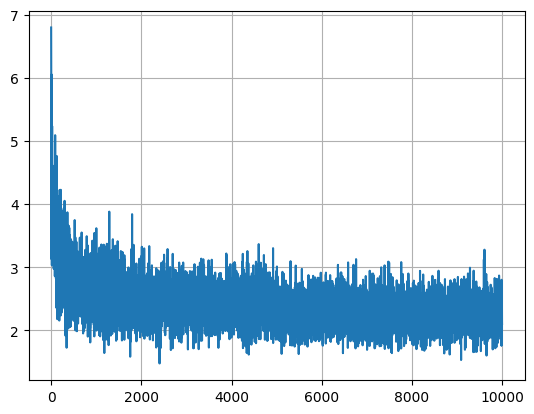

In [203]:
plt.plot(lossi)
plt.grid(True)

In [212]:
@torch.no_grad()
def evaluate(split: str):

    data_map = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }

    
    x, y = data_map[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    print(f"{split = }, {loss.item() = }")

In [213]:
evaluate("train")    
evaluate("val")    
evaluate("test")    

split = 'train', loss.item() = 2.265376329421997
split = 'val', loss.item() = 2.299886703491211
split = 'test', loss.item() = 2.2921314239501953
